# Create PCA Map and Determine Binding Energies of Atoms in CSD-1k and CSD-10k Dataset


In [1]:
#Import modules
from matplotlib import pylab as plt
from tqdm.notebook import tqdm
from skcosmo.decomposition import PCovR
from sklearn.decomposition import KernelPCA
from skcosmo.preprocessing import KernelNormalizer
from rascal.representations import SphericalInvariants
from rascal.utils import dump_obj, load_obj
import chemiscope
import numpy as np
import ase
from ase.io import read, write

In [2]:
def get_features(atoms_objects, batch_size=1000, progress_bar=True):
    '''Get average feature vectors for each structure in a list of atoms objects. 
        This requires soap to be set.
    '''
    struct_feat=[] #create empty feature vector of n_structures x n_features
    got_frame = False
    for frm in atoms_objects:
        if got_frame == False: 
            if all(sp in frm.get_atomic_numbers() for sp in [1,6,7,8]) == True:
                all_species = frm
                got_frame = True
    for i in tqdm(range(int(len(atoms_objects)/batch_size+0.9999)), disable = not progress_bar, leave=False): #Get feature vectors in batches of 1000
        for frm in atoms_objects[i*batch_size:(i+1)*batch_size]:
            frm.wrap(eps=1e-13) #wrap atoms in unit cell
        frames=[all_species.copy()] #add initial frame with all species
        frames.extend(atoms_objects[i*batch_size:(i+1)*batch_size]) #extend initial frame with frames of batch
        manager = soap.transform(frames) #calculate soap features for all structures in batch
        env_feat_batch = manager.get_features(soap)[len(all_species):] #get feature vectors for all structures in batch
        # (having removed the initial frame)
        atom_counter=0 #count atoms
        for ifrm,frm in enumerate(atoms_objects[i*batch_size:(i+1)*batch_size]): #iterate over frames in batch
            nat=len(frm) #count atoms in frame
            struct_feat.append(np.mean(env_feat_batch[atom_counter:atom_counter+nat],axis=0)) #average vectors
            # for atoms in the same frame. Done by averaging vectors between atom_counter and atom_counter + nat
            atom_counter+=nat #add atoms to counter
    struct_feat_array=np.asarray(struct_feat)
    return struct_feat_array

In [10]:
#Use very barebone soap hypers
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=4, #cutoff distance in angstroms
              max_radial=6, #no. of radial basis functions
              max_angular=4, #no. of angular basis functions
              gaussian_sigma_constant=0.4, #sigma width (i.e. amount of 'smearing')
              gaussian_sigma_type="Constant",
              cutoff_function_type="RadialScaling",
              cutoff_smooth_width=0.5,
              cutoff_function_parameters=
                    dict(
                            rate=1,
                            scale=2,
                            exponent=2
                        ),
              radial_basis="GTO",
              normalize=True,
              optimization=
                    dict(
                            Spline=dict(
                               accuracy=1.0e-05
                            )
                        ),
              compute_gradients=False #don't care about forces right now
              )
soap = SphericalInvariants(**hypers)

In [3]:
train_set = np.load('raw_data/CSD-10k_train_set.npy', allow_pickle=True)
csd_1k = read('raw_data/CSD-1k_combined.xyz', ':')

In [3]:
#Only get HCNO structures
test_set = []
for frm in csd_1k:
    X_frm = [len(np.where(frm.get_atomic_numbers() == sp)[0]) for sp in [1,6,7,8]]
    if len(frm) == sum(X_frm):
        test_set.append(frm)
print(f"Total number of HCNO structures: {len(test_set)}")
print(f"Total number of atoms: {sum([len(frm) for frm in test_set])}")

Total number of HCNO structures: 1000
Total number of atoms: 126380


In [4]:
#Get names of all crystals in the training dataset
crystals = []
for frm in train_set:
    frm.info['crystal'] = frm.info['name'].split('_')[0]
    crystals.append(frm.info['crystal'])

len(np.unique(crystals))    

2238

In [11]:
#Get features of training structures 
train_set_feats = get_features(train_set, batch_size=500)

  0%|          | 0/46 [00:00<?, ?it/s]

In [12]:
#Get features of test structures 
test_set_feats = get_features(test_set, batch_size=500)

  0%|          | 0/2 [00:00<?, ?it/s]

# Create Kernel PCA Map

In [13]:
all_feats = np.append(train_set_feats, test_set_feats, axis=0)

In [14]:
K = np.dot(all_feats, all_feats.T)

In [15]:
Kn = KernelNormalizer().fit_transform(K)

In [16]:
kpca = KernelPCA(kernel='precomputed', n_components=2)
kpca.fit(Kn)
t_kpca = kpca.transform(Kn)

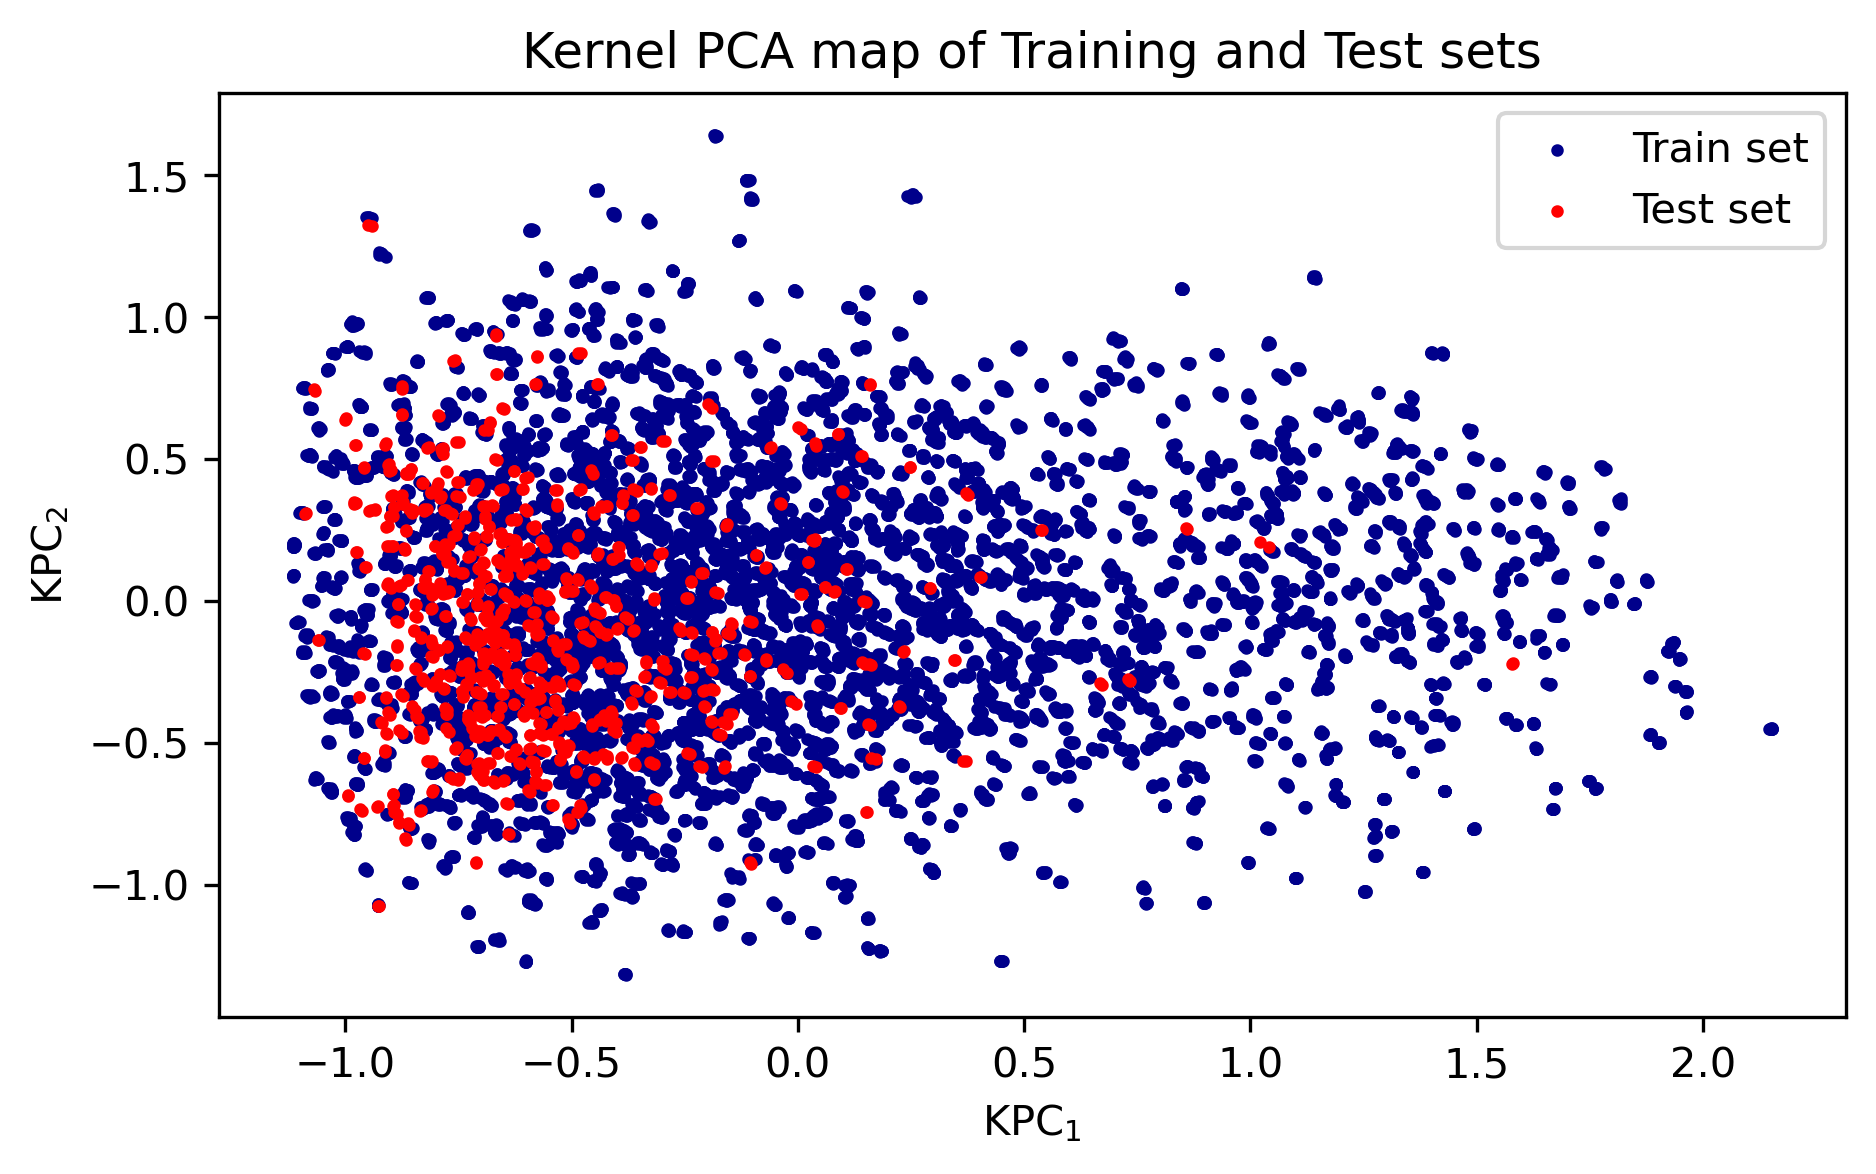

In [18]:
fig, ax = plt.subplots(1, figsize=(7,4), dpi=300)
ax.scatter(t_kpca[:-1000, 0],
                      t_kpca[:-1000, 1],
                      c="darkblue",
                      s=4,
                      vmin=-473.6,
                      vmax=-473.3,
                      rasterized=True,
                      label='Train set')
ax.scatter(t_kpca[-1000:, 0],
                      t_kpca[-1000:, 1],
                      c='red',
                      s=4,
                      vmin=-473.6,
                      vmax=-473.3,
                      rasterized=True,
                      label='Test set')
ax.set_xlabel('$\mathrm{KPC}_1$')
ax.set_ylabel('$\mathrm{KPC}_2$')
ax.legend()
ax.set_title('Kernel PCA map of Training and Test sets')
plt.savefig('figures/KPCA_map_train_test_sets.png')
plt.savefig('figures/KPCA_map_train_test_sets.pdf')
plt.show()

In [19]:
#find the "weirdest" training structure, i.e. the one with the furthest KPC1
print(np.argmax(t_kpca[:,0]))
print(len(train_set_feats), len(test_set_feats))

19753
22618 1000


In [20]:
weird_frame = train_set[np.argmax(t_kpca[:,0])]

In [21]:
print(f"Name of weird crystal: {weird_frame.info['name'].split('_')[0]}")

Name of weird crystal: COVSEM


In [22]:
#Get average force from training set structure
train_forces=[]
for frm in train_set:
    train_forces.extend(frm.arrays['forces'])
train_forces = np.asarray(train_forces).flatten()
print(np.mean(np.abs(train_forces)))

0.6035361965531877


In [23]:
#Get aveage force from test set structure
test_forces=[]
for frm in test_set:
    test_forces.extend(frm.arrays['PBE-D2_forces'])
test_forces = np.asarray(test_forces).flatten()
print(np.mean(np.abs(test_forces)))

0.33042287758685446


In [24]:
#Get average force of weird structure
np.mean(np.abs(weird_frame.arrays['forces'].flatten()))

0.8602900353030303

In [25]:
chemiscope.show(weird_frame)

/ssd/vprincip/code/miniconda3/envs/genshift2/lib/python3.10/site-packages/chemiscope/structures.py:305: UserWarning: value '[-0.44007619  0.10062372  1.10503443]' of type '<class 'numpy.ndarray'>' for the 'forces' property from ASE is not convertible to float or string, this property will be ignored.
  warnings.warn(
/ssd/vprincip/code/miniconda3/envs/genshift2/lib/python3.10/site-packages/chemiscope/structures.py:305: UserWarning: value '[4 3 2]' of type '<class 'numpy.ndarray'>' for the 'kpts' property from ASE is not convertible to float or string, this property will be ignored.
  warnings.warn(


ChemiscopeWidget(value=None, data='{"meta": {"name": " "}, "structures": [{"size": 44, "names": ["N", "N", "N"…

# Determine the binding energies of atoms using CSD-1k test set and the CSD-10k training set
See if the binding energies of different elements changes when they are determined using the CSD-1k test set and the CSD-10k training set. As the CSD-10k training set contained FPS-sampled crystals, these are likely to be thermodynamically less stable and may throw off the per-atom binding energies, as determined from the coefficients of a baselined model made using sklearn.

In [23]:
import pickle

In [24]:
with open('raw_data/CSD-10k_combined_w_kpts.pickle', 'rb') as f:
    full_db = pickle.load(f)

In [26]:
names = [key for key in full_db.keys()]

In [35]:
db_frames=[]
for name in names:
    db_frames.extend(full_db[name])

In [41]:
test_set[0].info

{'Name': 'TUQNOK',
 'energy_unit': 'eV',
 'force_unit': 'eV/angstrom',
 'PBE-D2_energy': -13824.51961084}

In [42]:
X_test=np.zeros((len(test_set),4), dtype=int); y_test=np.zeros(len(test_set), dtype=float); 
X_all=np.zeros((len(db_frames),4), dtype=int); y_all=np.zeros(len(db_frames), dtype=float)
for ifrm, frm in enumerate(db_frames):
    X_all[ifrm]=[len(np.where(frm.get_atomic_numbers() == sp)[0]) for sp in [1,6,7,8]]
    y_all[ifrm]=frm.info['energy']
for ifrm, frm in enumerate(test_set):
    X_test[ifrm]=[len(np.where(frm.get_atomic_numbers() == sp)[0]) for sp in [1,6,7,8]]
    y_test[ifrm]=frm.info['PBE-D2_energy']

In [45]:
from sklearn.linear_model import LinearRegression, Ridge
#Create baselined per-atom energy model
mlr_all = Ridge(fit_intercept=False, alpha=1e-4)
mlr_all.fit(X_all, y_all)
for spec, coef in zip(['H', 'C', 'N', 'O'], mlr_all.coef_):
    print(f"Per-atom energy for species {spec} : {coef} eV")

Per-atom energy for species H : -16.465763313701572 eV
Per-atom energy for species C : -154.71870283768186 eV
Per-atom energy for species N : -383.34368990099534 eV
Per-atom energy for species O : -566.2275097397115 eV


In [46]:
from sklearn.linear_model import LinearRegression, Ridge
#Create baselined per-atom energy model
mlr_test = Ridge(fit_intercept=False, alpha=1e-4)
mlr_test.fit(X_test, y_test)
for spec, coef in zip(['H', 'C', 'N', 'O'], mlr_test.coef_):
    print(f"Per-atom energy for species {spec} : {coef} eV")

Per-atom energy for species H : -16.338763039932918 eV
Per-atom energy for species C : -154.81660568032734 eV
Per-atom energy for species N : -383.617647355878 eV
Per-atom energy for species O : -566.5050406553827 eV


In [48]:
#Calculate difference between test set and full set:
print("Baselined model difference (full set - test set)")
for spec, coef_all, coef_test in zip(['H', 'C', 'N', 'O'], mlr_all.coef_, mlr_test.coef_):
    print(f"Per-atom energy difference for species {spec} : {coef_all-coef_test} eV")

Baselined model difference (full set - test set)
Per-atom energy difference for species H : -0.12700027376865464 eV
Per-atom energy difference for species C : 0.09790284264548177 eV
Per-atom energy difference for species N : 0.273957454882634 eV
Per-atom energy difference for species O : 0.27753091567115007 eV


Clearly, baselined energies are greater (i.e. less stable) in the full set compared to the test set for all species apart from hydrogen. This is quite significant for N and O, with almost 300 meV/atom difference